## Let us understand the data


The ISIC 2024 Kaggle competition involves developing AI algorithms to classify skin lesions as malignant or benign from cropped images resembling smartphone photos, aiming to improve early skin cancer detection and triage in settings lacking specialized dermatologic care. Participants will work with a dataset of labeled images, using a binary classification approach evaluated on the partial area under the ROC curve (pAUC) above 80% true positive rate (TPR).

ISIC2024/

├── train-image/   

│   ├── image/                     # Training image files

│   │   ├── ISIC_0073505.jpg

│   │   ├── ISIC_0073511.jpg

│   │   ├── ISIC_0073521.jpg

│   │   ├── ISIC_0073522.jpg

│   │   └── ... (400999 more images)

├── sample_submission.csv          # Sample submission file in the correct format

├── test-image.hdf5                # Test image data in HDF5 format (with a few test examples)

├── test-metadata.csv              # Metadata for test subset

├── train-image.hdf5               # Training image data in HDF5 format

├── train-metadata.csv             # Metadata for training set





/tmp/ipykernel_18/1012123000.py:9: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


Training Metadata Columns:
Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
  

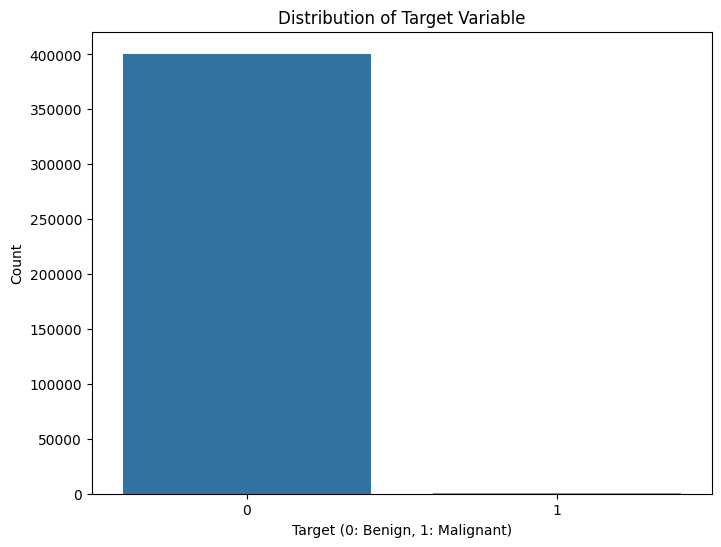

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


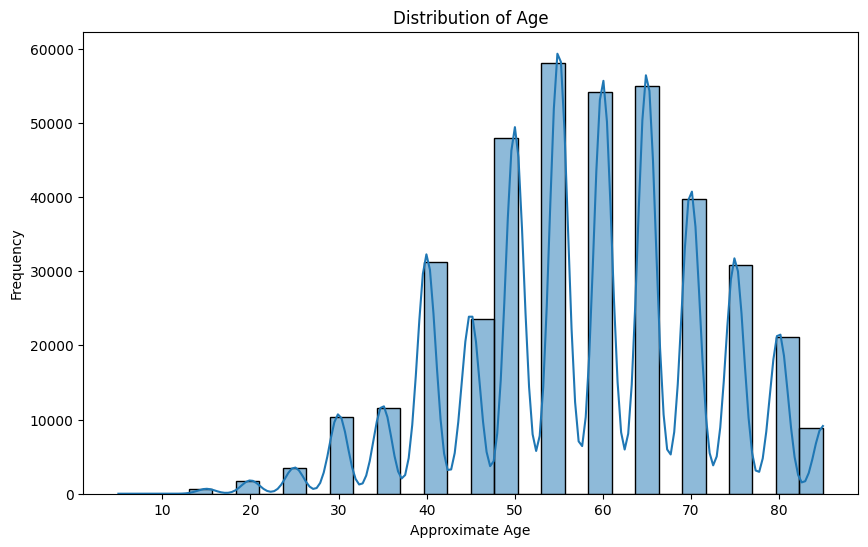

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Load metadata
train_metadata = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
test_metadata = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')

# Display the main columns of the metadata
print("Training Metadata Columns:")
print(train_metadata.columns)
print("\nTest Metadata Columns:")
print(test_metadata.columns)

# Display the first few rows of the training metadata
print("\nTraining Metadata Sample:")
print(train_metadata.head())

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_metadata)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Benign, 1: Malignant)')
plt.ylabel('Count')
plt.show()

# Plot the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(train_metadata['age_approx'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Approximate Age')
plt.ylabel('Frequency')
plt.show()


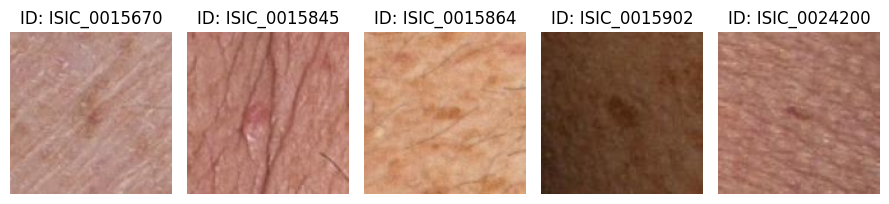

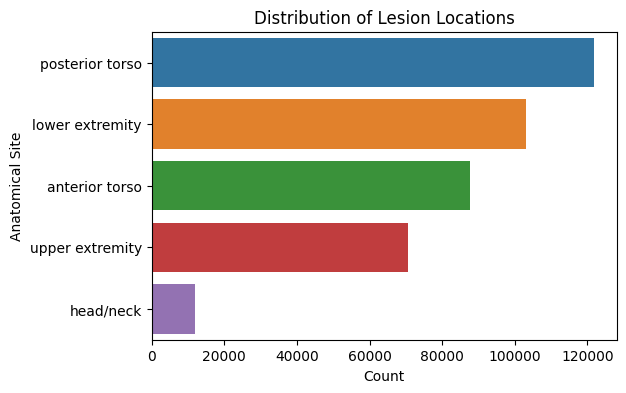

In [2]:

# Function to display a sample of images
def display_sample_images(image_dir, metadata, sample_size=5):
    fig, axes = plt.subplots(1, sample_size, figsize=(9, 3))
    for i, ax in enumerate(axes):
        isic_id = metadata.iloc[i]['isic_id']
        image_path = os.path.join(image_dir, f"{isic_id}.jpg")
        image = Image.open(image_path)
    
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"ID: {isic_id}")
    plt.tight_layout()
    plt.show()

# Display a sample of images from the training set
display_sample_images('/kaggle/input/isic-2024-challenge/train-image/image', train_metadata)

# Plot the distribution of lesion locations
plt.figure(figsize=(6, 4))
sns.countplot(y='anatom_site_general', data=train_metadata, order=train_metadata['anatom_site_general'].value_counts().index)
plt.title('Distribution of Lesion Locations')
plt.xlabel('Count')
plt.ylabel('Anatomical Site')
plt.show()


## Building Feature Eng. 

 - based on (https://www.kaggle.com/code/snnclsr/lgbm-baseline-with-new-features)

In [3]:
def feature_engineering(df):
    # Ratio of the minor axis to the long diameter, indicating lesion elongation
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]

    # Shape index: area to perimeter squared ratio, indicating lesion compactness
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)

    # Absolute difference in hue inside vs outside the lesion, indicating color contrast
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()

    # Absolute difference in luminance inside vs outside the lesion, indicating brightness contrast
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()

    # Euclidean distance in LAB color space, indicating overall color difference
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)

    # Combined measure of border irregularity and asymmetry, indicating complexity
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]

    # Ratio of color standard deviation to radial color standard deviation, indicating color uniformity
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]

    # 3D distance from the origin, indicating lesion's spatial position
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 

    # Ratio of perimeter to area, indicating lesion border complexity
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]

    # Visibility score combining contrast and color uniformity
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]

    # Concatenated anatomical site and lesion location, for categorical modeling
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]

    # Interaction between symmetry and border complexity
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]

    # Ratio of color standard deviation inside to outside lesion, indicating color consistency
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    # Interaction between lesion size and patient's age
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]

    # Interaction between hue and color standard deviation
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]

    # Average of normalized border, color, and eccentricity scores
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3

    # Combined measure of shape complexity
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]

    # Combined measure of color contrast
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]

    # Log-transformed lesion area
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)

    # Lesion size normalized by age
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]

    # Mean of hue values inside and outside the lesion
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2

    # Standard deviation of color contrast values
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)

    # Composite index combining color variance, area-to-perimeter ratio, and asymmetry
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3

    # 3D orientation of the lesion
    df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])

    # Average of color differences
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3

    # Interaction between symmetry and perimeter
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]

    # Composite lesion index combining area-to-perimeter ratio, eccentricity, color variance, and symmetry
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols


In [4]:
from sklearn.preprocessing import OrdinalEncoder


# Apply feature engineering
df_train, new_num_cols, new_cat_cols = feature_engineering(train_metadata.copy())
df_test, _, _ = feature_engineering(test_metadata.copy())

# Define numerical columns, including new features
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] + new_num_cols

# Define categorical columns, including new features
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols

# Combine all feature columns
train_cols = num_cols + cat_cols

# Encode categorical features
category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

# Repeat for test set if needed
X_cat_test = category_encoder.transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat_test[:, c]

# Now df_train and df_test are ready for modeling with the updated feature set


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

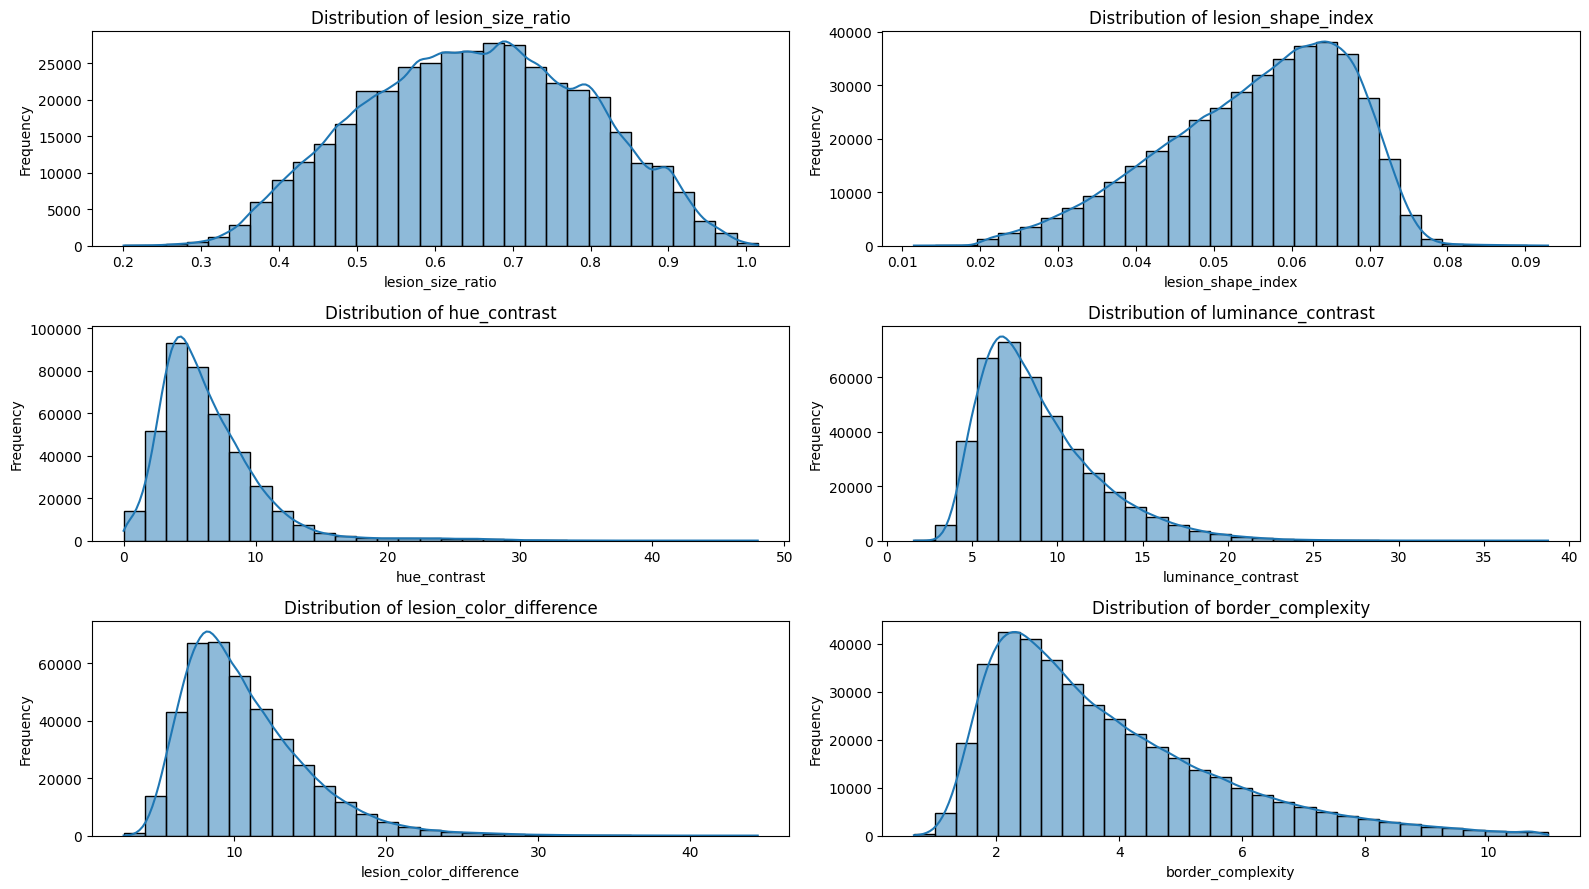

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few new numerical features for plotting
features_to_plot = [
    "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
    "luminance_contrast", "lesion_color_difference", "border_complexity"
]

# Plot the distribution of the selected numerical features
plt.figure(figsize=(16, 9))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


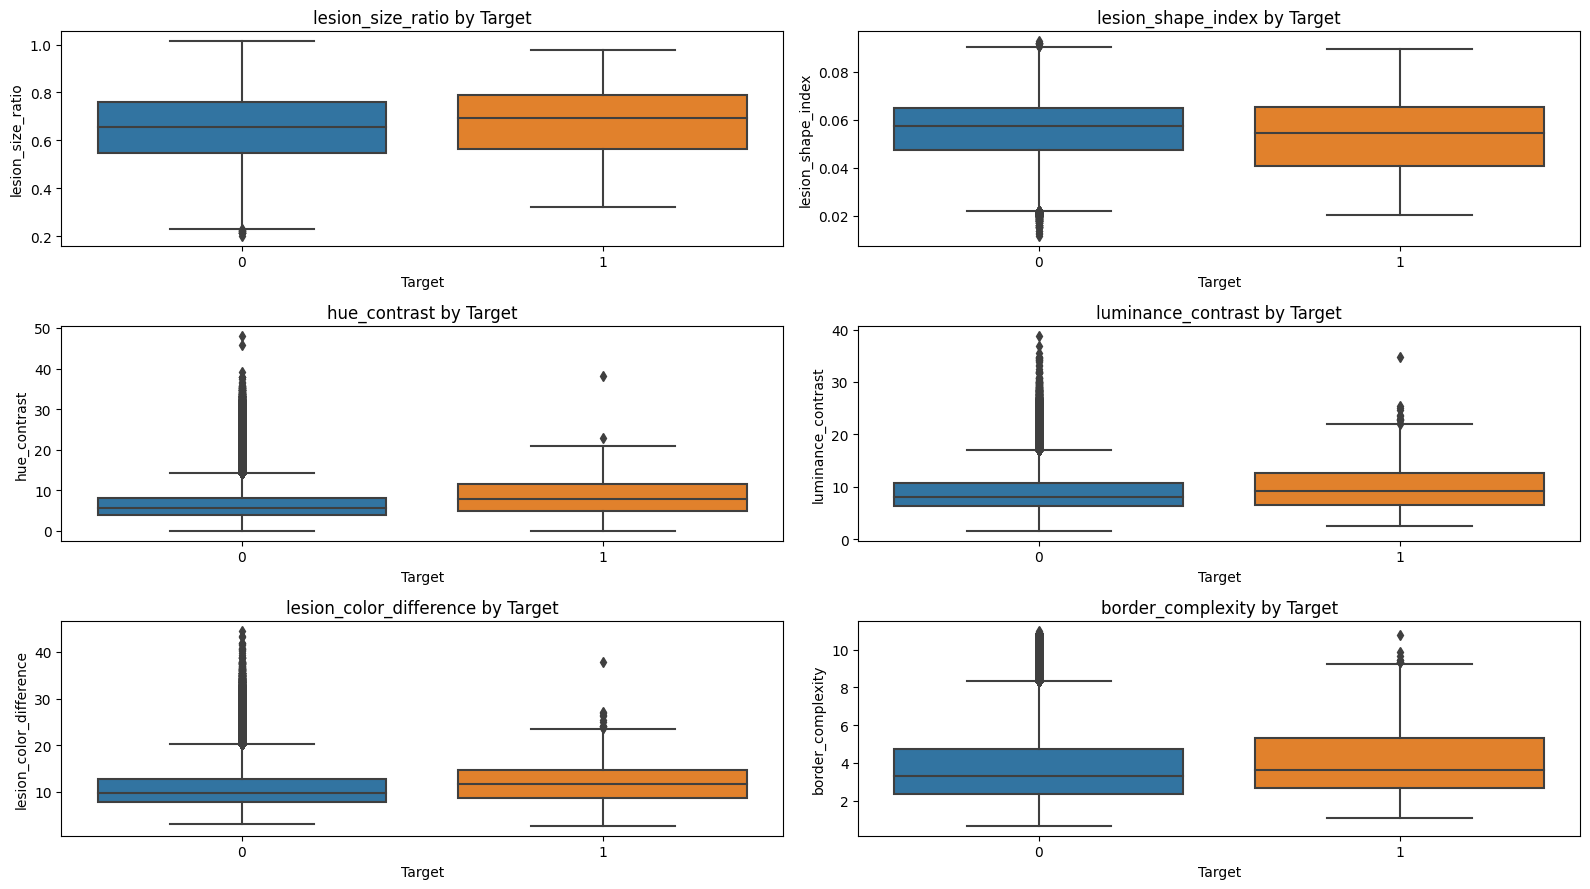

In [6]:
plt.figure(figsize=(16, 9))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='target', y=feature, data=df_train)
    plt.title(f'{feature} by Target')
    plt.xlabel('Target')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


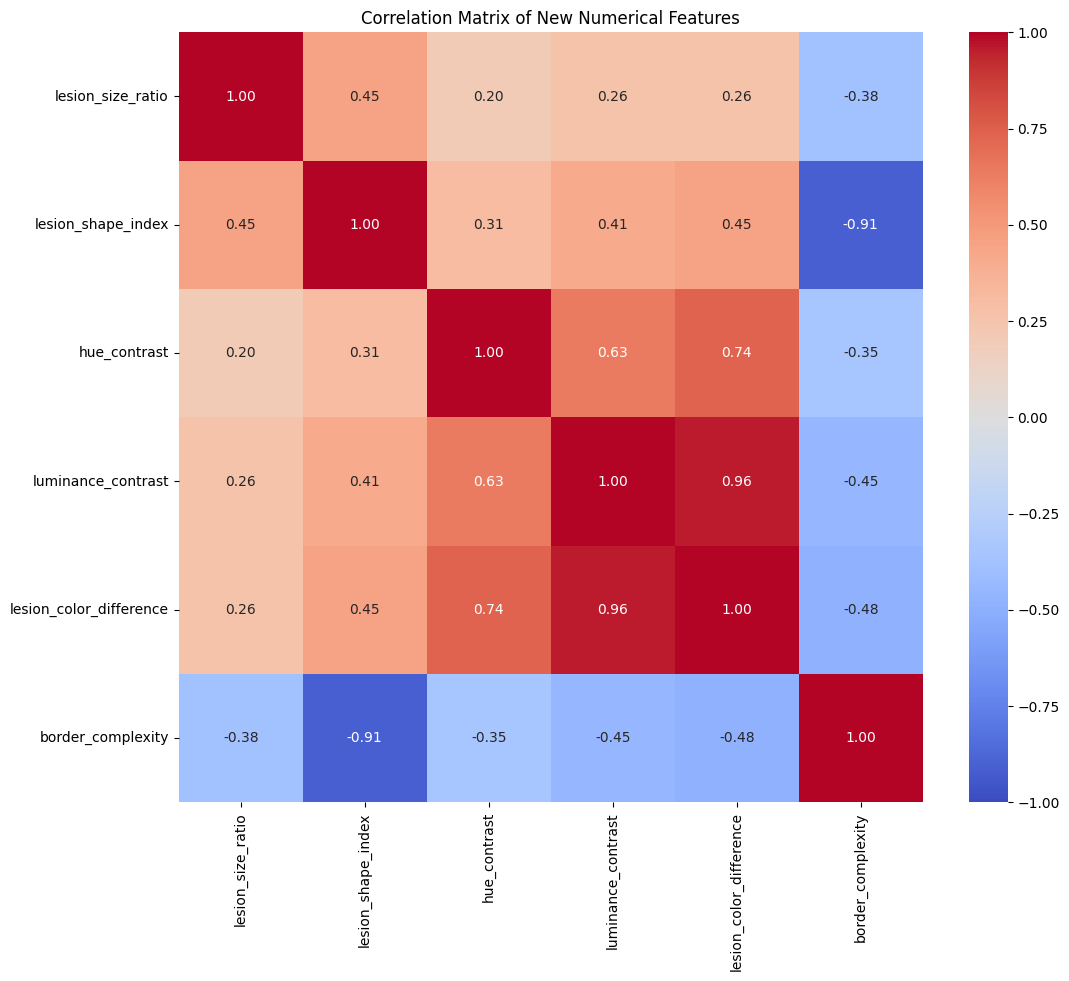

In [7]:
# Calculate the correlation matrix for the new numerical features
corr_matrix = df_train[features_to_plot].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of New Numerical Features')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

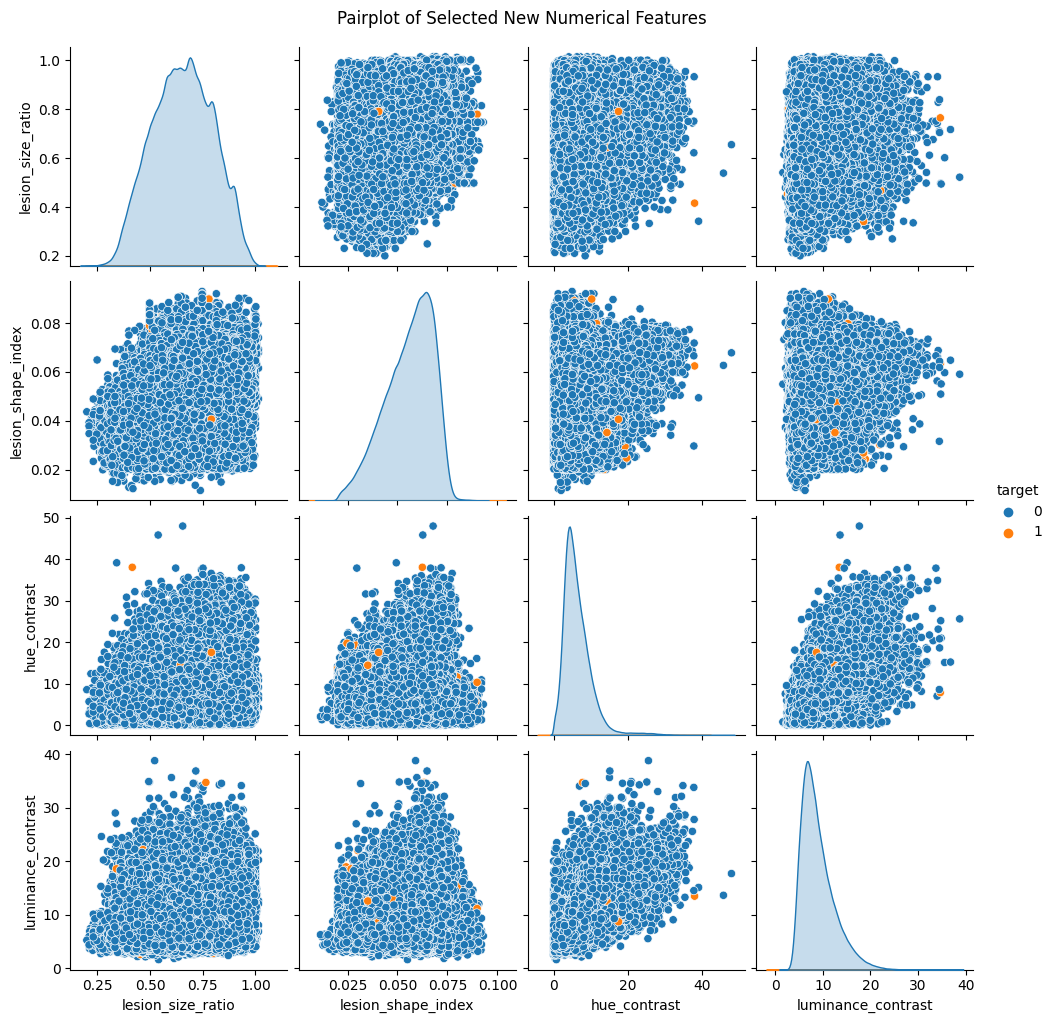

In [8]:
sns.pairplot(df_train, vars=features_to_plot[:4], hue="target", diag_kind="kde")
plt.suptitle('Pairplot of Selected New Numerical Features', y=1.02)
plt.show()


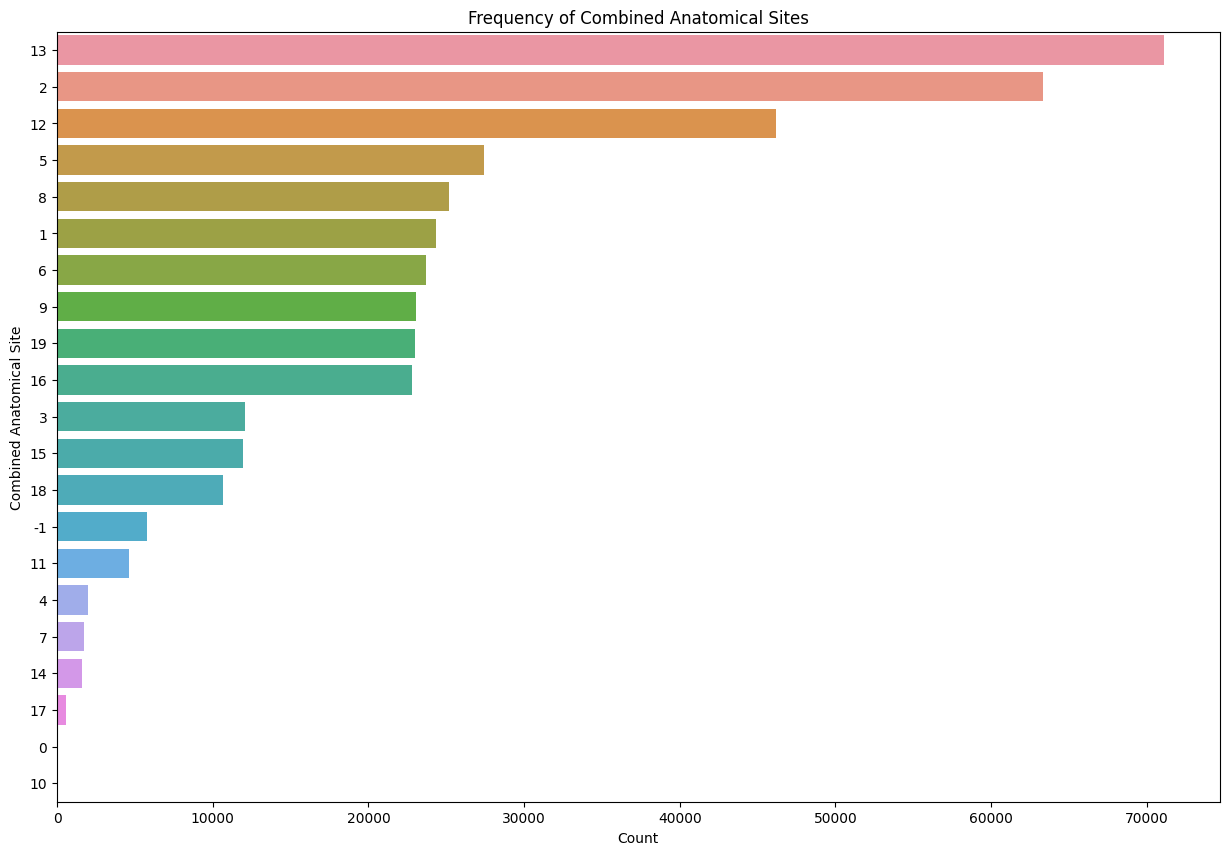

In [9]:
plt.figure(figsize=(15, 10))
sns.countplot(y='combined_anatomical_site', data=df_train, order=df_train['combined_anatomical_site'].value_counts().index)
plt.title('Frequency of Combined Anatomical Sites')
plt.xlabel('Count')
plt.ylabel('Combined Anatomical Site')
plt.show()

